In [10]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



In [11]:
DATA_DIR = os.getcwd()
FEATURES_DIR = DATA_DIR

In [12]:
egemaps_features = np.load(os.path.join(FEATURES_DIR, "opensmile/egemaps_features.npy"))
egemaps_labels = np.load(os.path.join(FEATURES_DIR, "opensmile/egemaps_labels.npy"))

# Wav2Vec2
wav2vec2_features = np.load(os.path.join(FEATURES_DIR, "wav2vec2 features/wav2vec2_features.npy"))
wav2vec2_labels = np.load(os.path.join(FEATURES_DIR, "wav2vec2 features/labels.npy"))

# WavLM
wavlm_features = np.load(os.path.join(FEATURES_DIR, "wavLm features/wavlm_features.npy"))
wavlm_labels = np.load(os.path.join(FEATURES_DIR, "wavLm features/wavlm_labels.npy"))



In [13]:
print(f"eGeMAPS: {egemaps_features.shape}, Wav2Vec2: {wav2vec2_features.shape}, WavLM: {wavlm_features.shape}")


eGeMAPS: (6930, 88), Wav2Vec2: (6930, 768), WavLM: (6930, 768)


In [14]:
labels = egemaps_labels  # Use egemaps_labels as reference

# ============================
# Concatenate features
# ============================
X = np.concatenate([egemaps_features, wav2vec2_features, wavlm_features], axis=1)
y = labels

print(f"Combined features shape: {X.shape}")



Combined features shape: (6930, 1624)


## Individual models

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



======== Random Forest ========


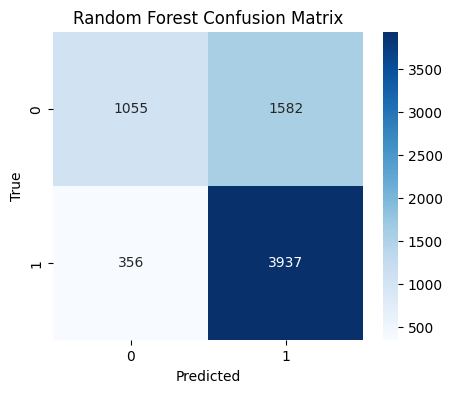

              precision    recall  f1-score   support

           0      0.748     0.400     0.521      2637
           1      0.713     0.917     0.802      4293

    accuracy                          0.720      6930
   macro avg      0.731     0.659     0.662      6930
weighted avg      0.726     0.720     0.695      6930



In [20]:


print("\n======== Random Forest ========")
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Random Forest Confusion Matrix")
plt.show()
target_names = [str(c) for c in le.classes_]

print(classification_report(all_true, all_pred, target_names=target_names, digits=3))



======== XGBoost ========


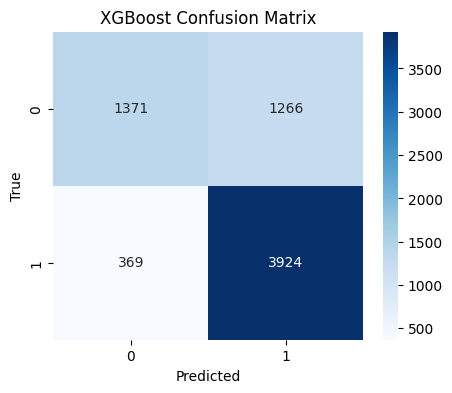

              precision    recall  f1-score   support

           0      0.788     0.520     0.626      2637
           1      0.756     0.914     0.828      4293

    accuracy                          0.764      6930
   macro avg      0.772     0.717     0.727      6930
weighted avg      0.768     0.764     0.751      6930



In [21]:
print("\n======== XGBoost ========")
clf = XGBClassifier(
    n_estimators=250, 
    learning_rate=0.05, 
    max_depth=10,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42
)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("XGBoost Confusion Matrix")
plt.show()
target_names = [str(c) for c in le.classes_]

print(classification_report(all_true, all_pred, target_names=target_names, digits=3))



======== KNN ========


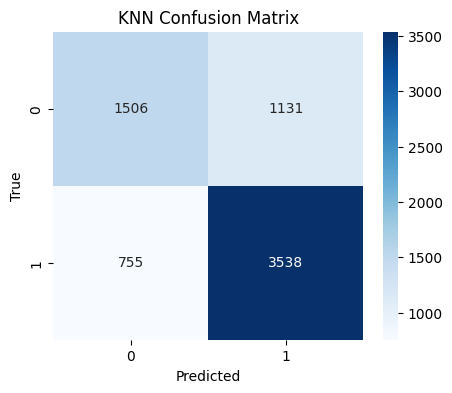

              precision    recall  f1-score   support

           0      0.666     0.571     0.615      2637
           1      0.758     0.824     0.790      4293

    accuracy                          0.728      6930
   macro avg      0.712     0.698     0.702      6930
weighted avg      0.723     0.728     0.723      6930



In [22]:
print("\n======== KNN ========")
clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("KNN Confusion Matrix")
plt.show()
target_names = [str(c) for c in le.classes_]

print(classification_report(all_true, all_pred, target_names=target_names, digits=3))



======== ANN ========


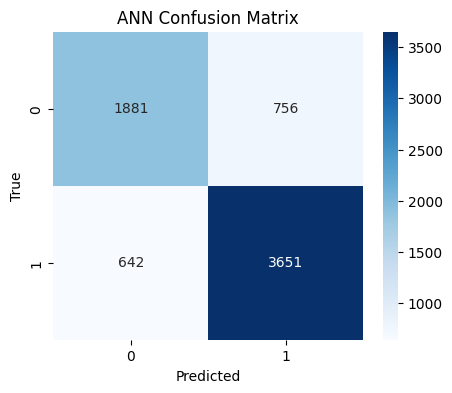

              precision    recall  f1-score   support

           0      0.746     0.713     0.729      2637
           1      0.828     0.850     0.839      4293

    accuracy                          0.798      6930
   macro avg      0.787     0.782     0.784      6930
weighted avg      0.797     0.798     0.797      6930



In [23]:
from sklearn.neural_network import MLPClassifier

print("\n======== ANN ========")
clf = MLPClassifier(hidden_layer_sizes=(256,128), max_iter=300, random_state=42)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("ANN Confusion Matrix")
plt.show()
target_names = [str(c) for c in le.classes_]

print(classification_report(all_true, all_pred, target_names=target_names, digits=3))



======== Logistic Regression ========


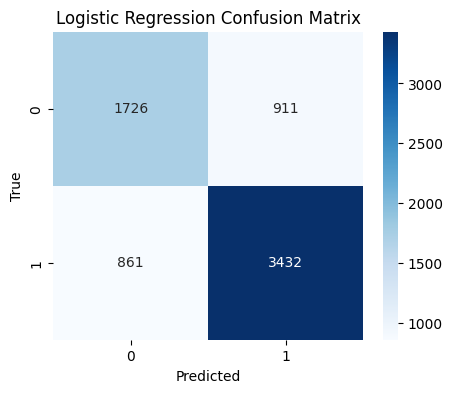

              precision    recall  f1-score   support

           0      0.667     0.655     0.661      2637
           1      0.790     0.799     0.795      4293

    accuracy                          0.744      6930
   macro avg      0.729     0.727     0.728      6930
weighted avg      0.743     0.744     0.744      6930



In [24]:
from sklearn.linear_model import LogisticRegression

print("\n======== Logistic Regression ========")
clf = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Logistic Regression Confusion Matrix")
plt.show()
target_names = [str(c) for c in le.classes_]

print(classification_report(all_true, all_pred, target_names=target_names, digits=3))


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n======== AdaBoost ========")
base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42)

clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

all_true, all_pred = [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

# Convert label classes to strings for plotting & report
class_labels = [str(c) for c in np.unique(y)]

# Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AdaBoost Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_true, all_pred, target_names=class_labels, digits=3))



======== AdaBoost ========


KeyboardInterrupt: 


======== CNN ========


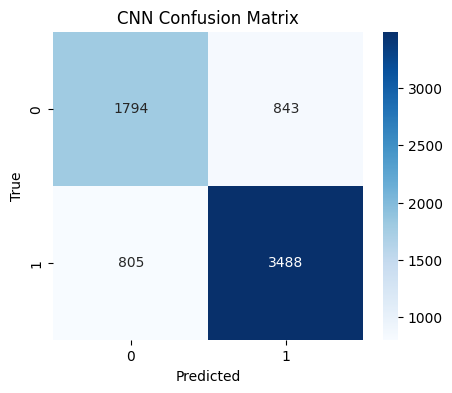

              precision    recall  f1-score   support

           0      0.690     0.680     0.685      2637
           1      0.805     0.812     0.809      4293

    accuracy                          0.762      6930
   macro avg      0.748     0.746     0.747      6930
weighted avg      0.762     0.762     0.762      6930



In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("\n======== CNN ========")

class SimpleCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
num_classes = len(np.unique(y))

all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    model = SimpleCNN(input_dim, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):  # reduce epochs for speed
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test_tensor), dim=1)
        all_true.extend(y_test_tensor.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

class_labels = [str(c) for c in np.unique(y)]

# Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_true, all_pred, target_names=class_labels, digits=3))

In [ ]:
print("\n======== CNN ========")
all_true, all_pred = [], []

input_dim = X.shape[1]
num_classes = len(np.unique(y))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = SimpleCNN(input_dim, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train for 20 epochs
    for epoch in range(20):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = torch.argmax(outputs, dim=1)
        all_true.extend(y_test_tensor.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

    # Save fold model
    torch.save(model.state_dict(), f"cnn_fold{fold}.pth")



In [ ]:
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.show()

print("CNN Classification Report:")
print(classification_report(all_true, all_pred))


## Hyper Parameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

print("🔹 ANN Hyperparameter Tuning")

param_grid = {
    "hidden_layer_sizes": [(128,), (256, 128), (512, 256)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001],
    "learning_rate": ["constant", "adaptive"]
}

ann = MLPClassifier(max_iter=500, random_state=42)

grid = GridSearchCV(ann, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best ANN Parameters:", grid.best_params_)
print("Best ANN Accuracy: {:.3f}".format(grid.best_score_))


🔹 ANN Hyperparameter Tuning
Best ANN Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128), 'learning_rate': 'constant', 'solver': 'adam'}
Best ANN Accuracy: 0.668


In [31]:
from sklearn.neighbors import KNeighborsClassifier

print("🔹 KNN Hyperparameter Tuning")

param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # Manhattan (1) or Euclidean (2)
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best KNN Parameters:", grid.best_params_)
print("Best KNN Accuracy: {:.3f}".format(grid.best_score_))


🔹 KNN Hyperparameter Tuning
Best KNN Parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Best KNN Accuracy: 0.622


In [32]:
from sklearn.linear_model import LogisticRegression

print("🔹 Logistic Regression Hyperparameter Tuning")

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"],
    "max_iter": [500]
}

logreg = LogisticRegression()
grid = GridSearchCV(logreg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best Logistic Regression Parameters:", grid.best_params_)
print("Best Logistic Regression Accuracy: {:.3f}".format(grid.best_score_))


🔹 Logistic Regression Hyperparameter Tuning
Best Logistic Regression Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.664


In [33]:
from xgboost import XGBClassifier

print("🔹 XGBoost Hyperparameter Tuning")

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 10, 12],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1],
    "colsample_bytree": [0.7, 0.9, 1]
}

xgb = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor", random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best XGBoost Parameters:", grid.best_params_)
print("Best XGBoost Accuracy: {:.3f}".format(grid.best_score_))


🔹 XGBoost Hyperparameter Tuning


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import numpy as np

print("🔹 CNN Hyperparameter Tuning")

param_grid = {
    "hidden1": [256, 512],
    "hidden2": [128, 256],
    "lr": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [10, 20]  # use smaller for speed
}

input_dim = X.shape[1]
num_classes = len(np.unique(y))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_acc = 0
best_params = {}

for h1 in param_grid["hidden1"]:
    for h2 in param_grid["hidden2"]:
        for lr in param_grid["lr"]:
            for batch_size in param_grid["batch_size"]:
                for epochs in param_grid["epochs"]:
                    fold_acc = []
                    for train_idx, test_idx in kf.split(X, y):
                        X_train, X_test = X[train_idx], X[test_idx]
                        y_train, y_test = y[train_idx], y[test_idx]

                        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
                        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
                        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

                        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
                        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

                        class CNN(nn.Module):
                            def __init__(self, input_dim, h1, h2, num_classes):
                                super().__init__()
                                self.fc1 = nn.Linear(input_dim, h1)
                                self.fc2 = nn.Linear(h1, h2)
                                self.fc3 = nn.Linear(h2, num_classes)
                            def forward(self, x):
                                x = F.relu(self.fc1(x))
                                x = F.relu(self.fc2(x))
                                return self.fc3(x)

                        model = CNN(input_dim, h1, h2, num_classes).to(device)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                        criterion = nn.CrossEntropyLoss()

                        for epoch in range(epochs):
                            model.train()
                            for xb, yb in train_loader:
                                optimizer.zero_grad()
                                out = model(xb)
                                loss = criterion(out, yb)
                                loss.backward()
                                optimizer.step()

                        # Eval
                        model.eval()
                        with torch.no_grad():
                            preds = torch.argmax(model(X_test_tensor), dim=1)
                            acc = (preds.cpu().numpy() == y_test_tensor.cpu().numpy()).mean()
                            fold_acc.append(acc)

                    mean_acc = np.mean(fold_acc)
                    if mean_acc > best_acc:
                        best_acc = mean_acc
                        best_params = {"h1": h1, "h2": h2, "lr": lr, "batch_size": batch_size, "epochs": epochs}

print("Best CNN Params:", best_params)
print("Best CNN Accuracy: {:.3f}".format(best_acc))


## Logistic regression, XGBoost, Random Forest, KNN

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
xgb = XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=10, tree_method="gpu_hist", predictor="gpu_predictor", random_state=42)

ensemble = VotingClassifier(
    estimators=[("knn", knn), ("logreg", logreg), ("rf", rf), ("xgb", xgb)],
    voting="soft",  # use probability voting
    n_jobs=-1
)


In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accur=[]
all_true = []
all_pred = []

fold = 1
for train_index, test_index in kf.split(X, y):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train ensemble
    ensemble.fit(X_train, y_train)

    # Save model for this fold
    model_path = os.path.join(FEATURES_DIR, f"ensemble_fold{fold}.joblib")
    joblib.dump(ensemble, model_path)
    print(f"Saved model to {model_path}")

    # Predict
    y_pred = ensemble.predict(X_test)
    all_true.extend(y_test)
    all_pred.extend(y_pred)

    acc = accuracy_score(y_test, y_pred)
    accur.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    fold += 1
print(f"final accuracy:{sum(accur)/len(accur)}")


In [ ]:
cm = confusion_matrix(all_true, all_pred, labels=np.unique(y))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (10-Fold CV)")
plt.show()

print("\nClassification Report:")
print(classification_report(all_true, all_pred))
